## <b>Bank Churn prediction


 
### **Context**:

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### **Objective**:

Let us consider you are working as Data scientist with the  bank and you need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### **Data Dictionary**:

The case study is from an open-source dataset from Kaggle.The dataset contains 10,000 sample points with 14 distinct features as follows:

CustomerId: Unique ID which is assigned to each customer

Surname: Last name of the customer
 
CreditScore: It defines the credit history of the customer.
  
Geography: A customer’s location 
   
Gender: It defines the Gender of the customer
   
Age: Age of the customer 
    
Tenure: Number of years for which the customer has been with the bank

NumOfProducts: refers to the number of products that a customer has purchased through the bank.

Balance: Account balance

HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

EstimatedSalary: Estimated salary 

isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

Exited : whether or not the customer left the bank within six month. It can take two values 

0=No ( Customer did not leave the bank )
1=Yes ( Customer left the bank )

### Importing necessary libraries

In [ ]:
## Install Keras Tuner
!pip install keras-tuner 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import random
from tensorflow.keras import backend
random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

C:\Users\hp\AppData\Local\Temp\ipykernel_17788\1345906316.py:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


### Read the dataset

In [ ]:
data=pd.read_csv('Churn.csv')


### Data Overview

#### Displaying the first few rows of the dataset

In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Checking the shape of the dataset

In [ ]:
data.shape

(10000, 14)

#### Checking the data types of the columns for the dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### Checking for duplicate values

In [ ]:
data.duplicated().sum()

0

#### Checking for missing values

In [ ]:
data.isnull().sum()/data.isnull().count()*100

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [ ]:
# creating a copy of the data so that original data remains unchanged
df=data.copy()

#### Drop the columns which are unique for all users 

In [ ]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

### Exploratory Data Analysis


- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. How is the target feature related to each categorical feature?
2. How is the target feature related to each numerical feature?
3. How are the features correlated to each other?
4. How does the distribution vary for each feature?

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [ ]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
num_col=df.select_dtypes(include=np.number).columns.tolist()
num_col

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

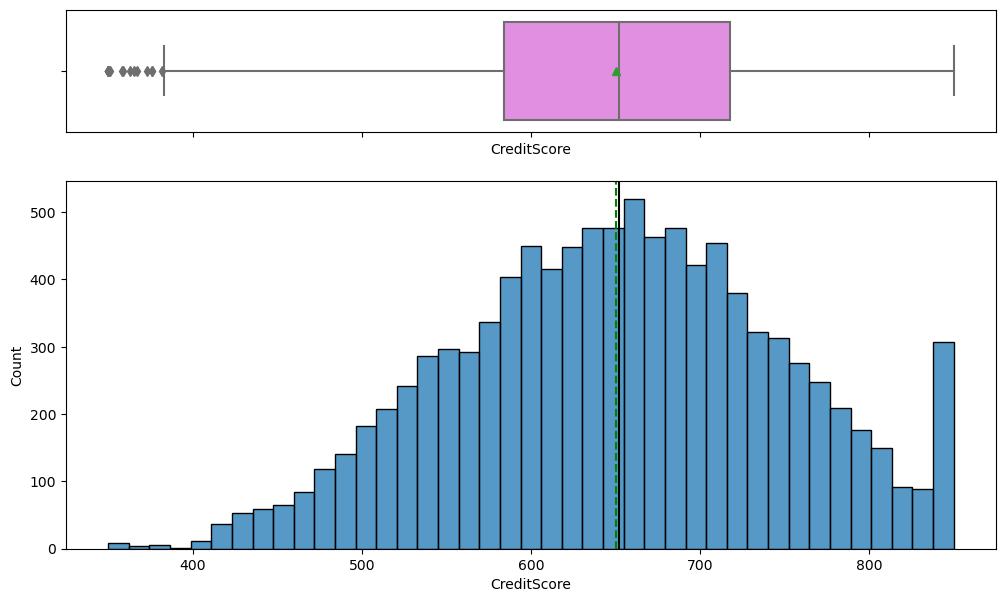

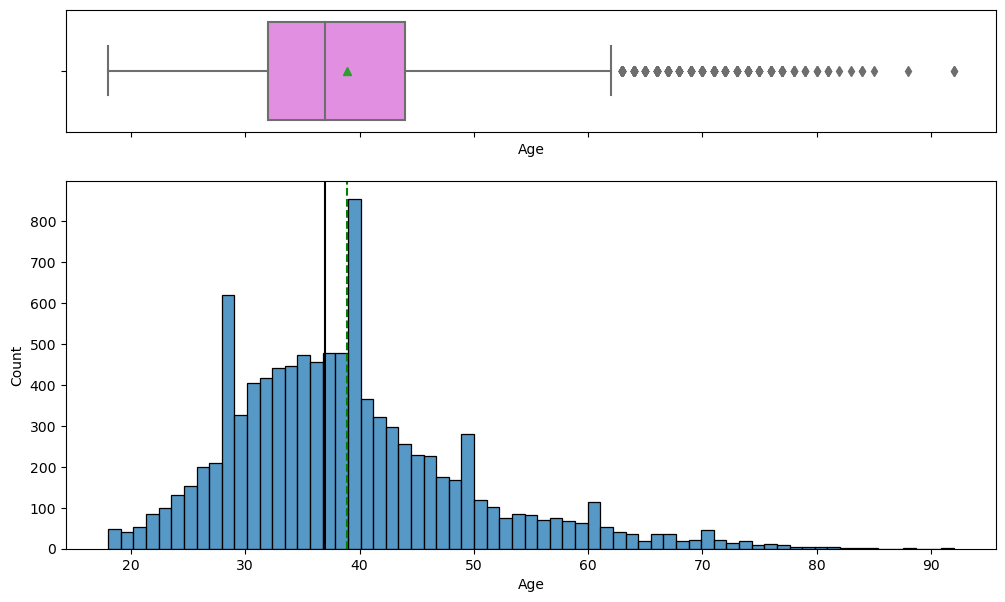

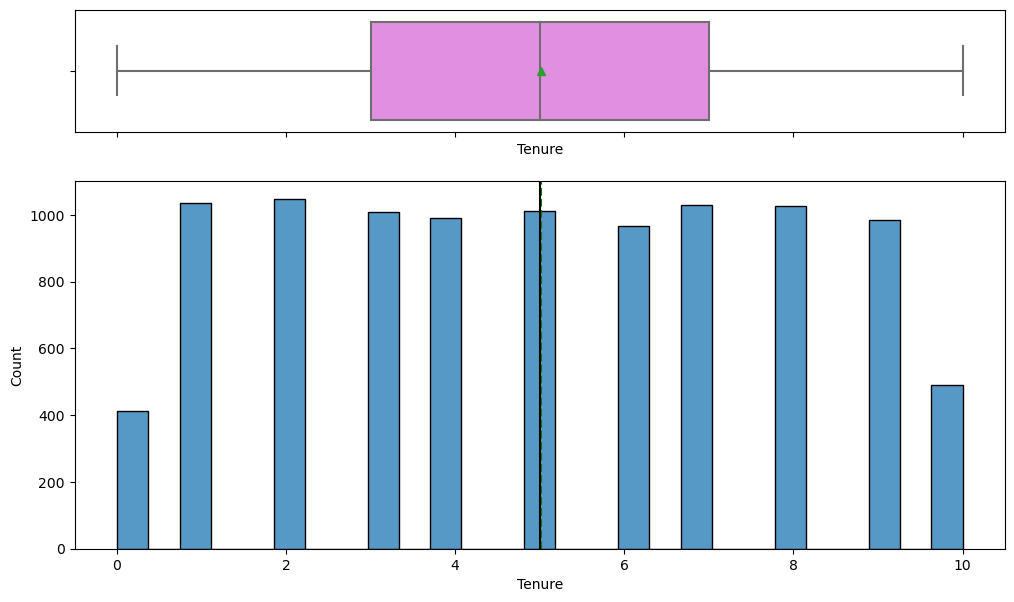

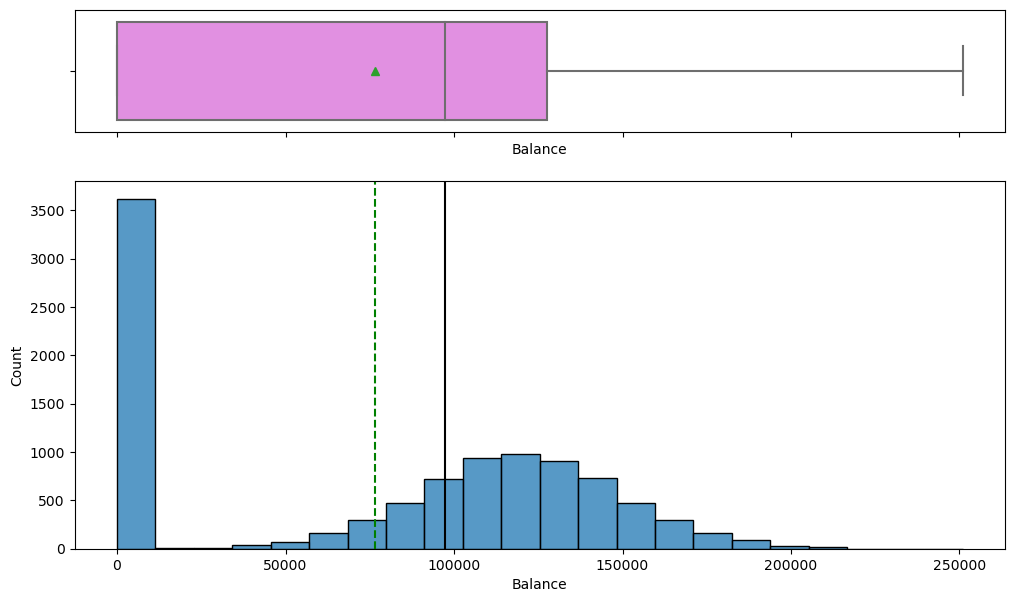

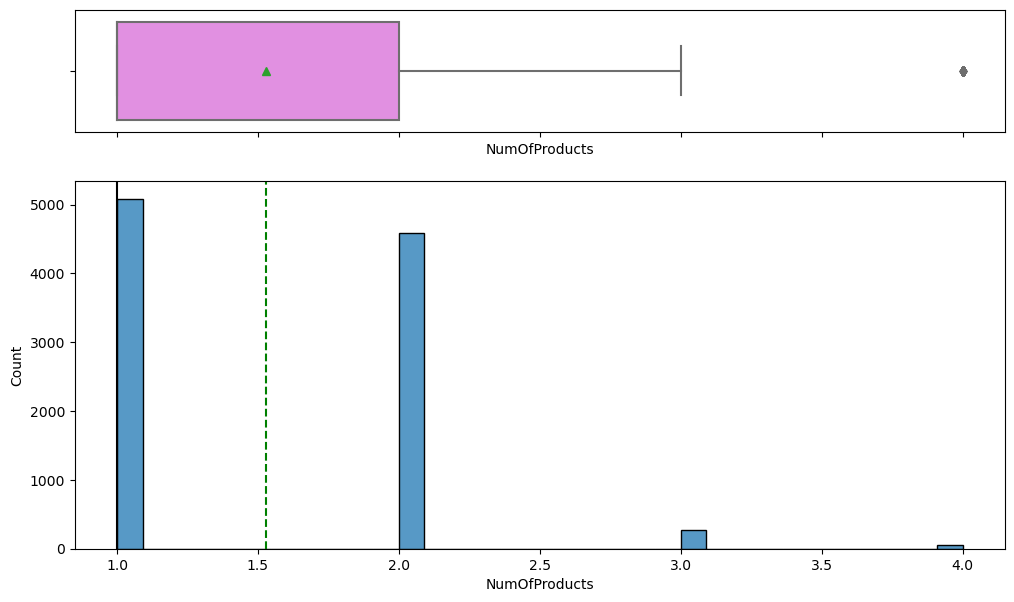

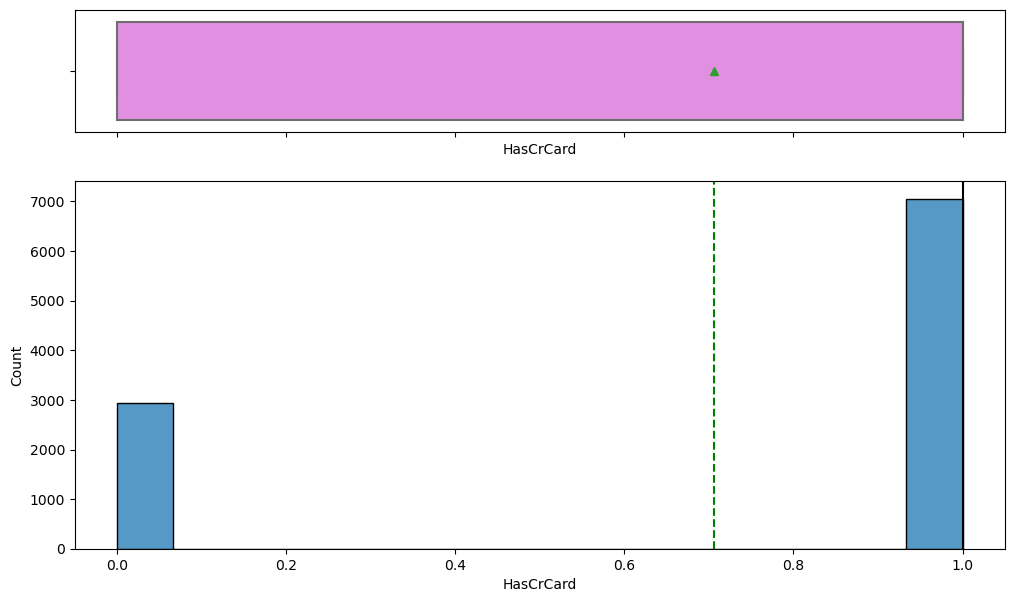

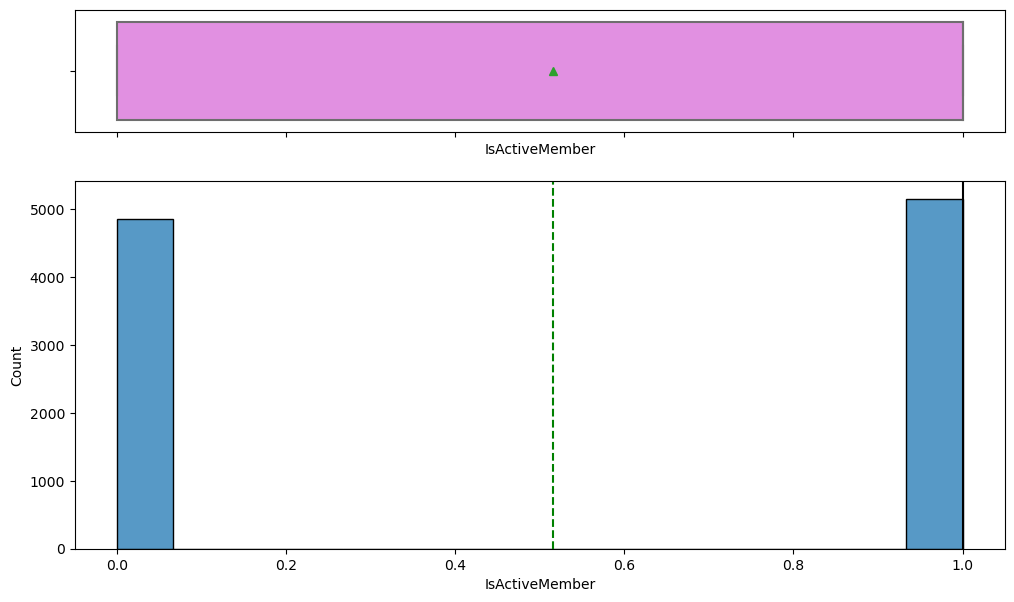

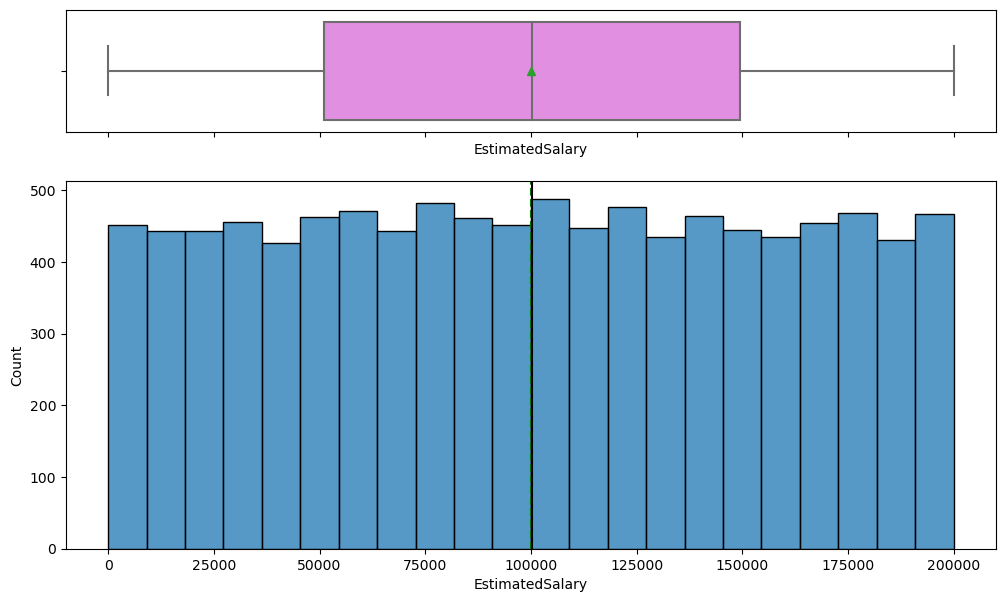

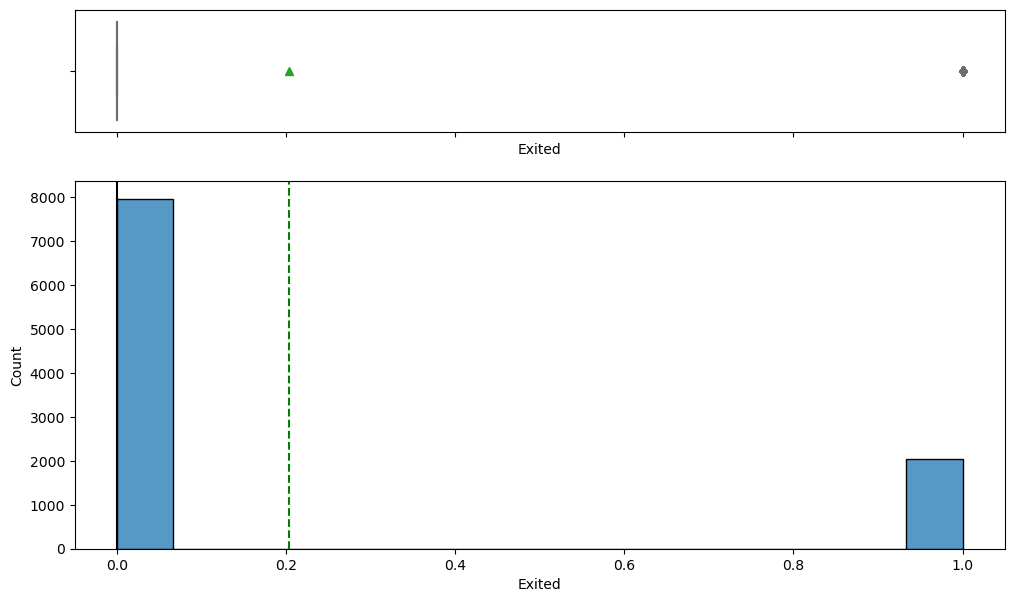

In [ ]:
for features in df[num_col]:
    histogram_boxplot(df, features, figsize=(12, 7), kde=False, bins=None)
    

Observartion:

* Credit score is almost normally distributed with few outliers in the lower side
* Age is right skewed outliers in theupper side
* Balance is left skewed 
* Num of products has an outlier in the upper side

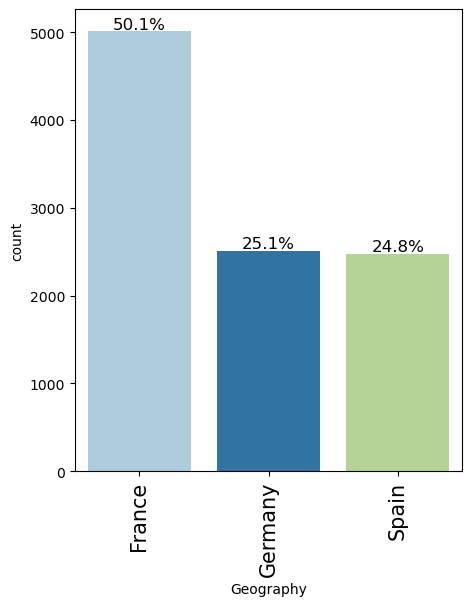

In [ ]:
labeled_barplot(df,'Geography' , perc=True)

Observation:
    
* 50.1% of customers come from France followed by Germany with 25.1% then Spain with 24.8%

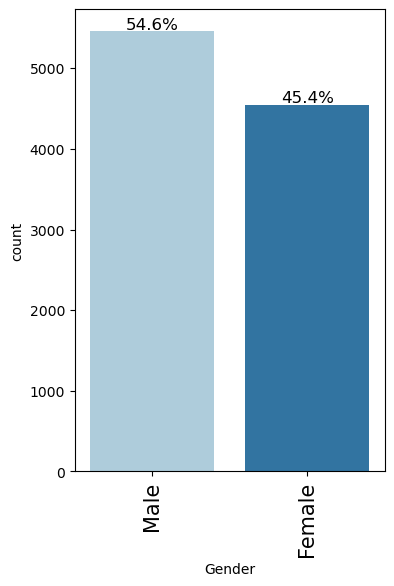

In [ ]:
labeled_barplot(df,'Gender' , perc=True)

Observation:
    
* 54.6% of bank's customers are male

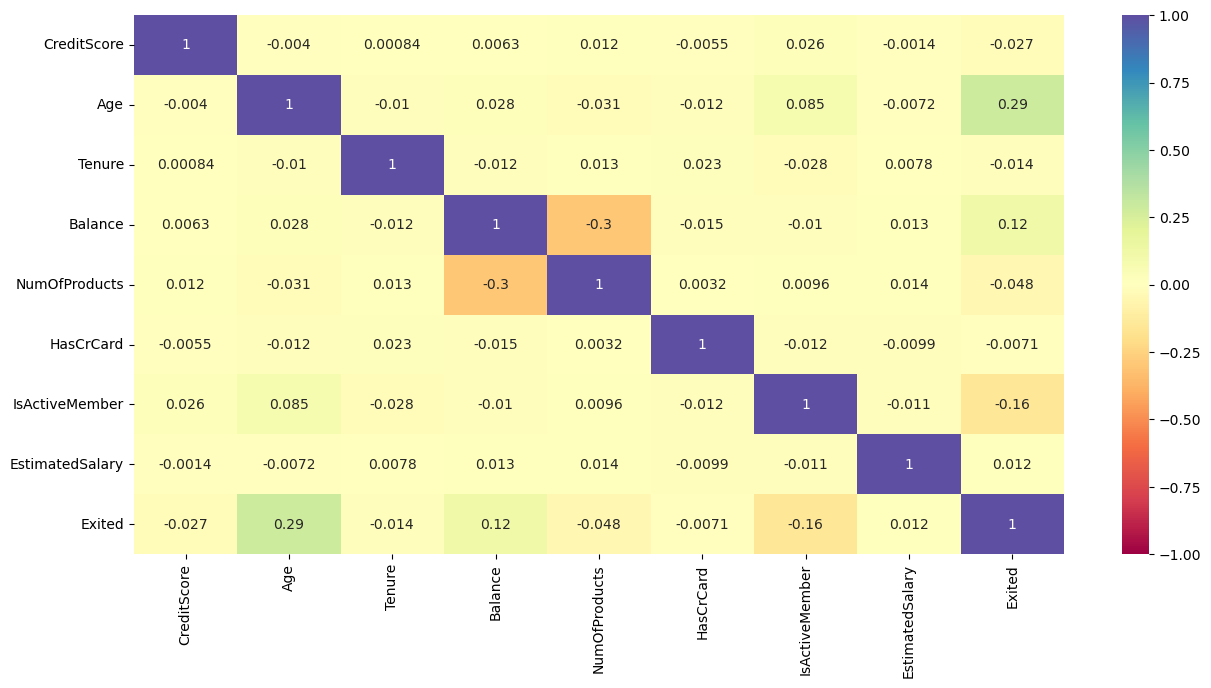

In [ ]:
# Heatmap to check the correlation between numerical data
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1)
plt.show()

Observation:
    
* There is not strong relationship between variables and between variables and the target variable

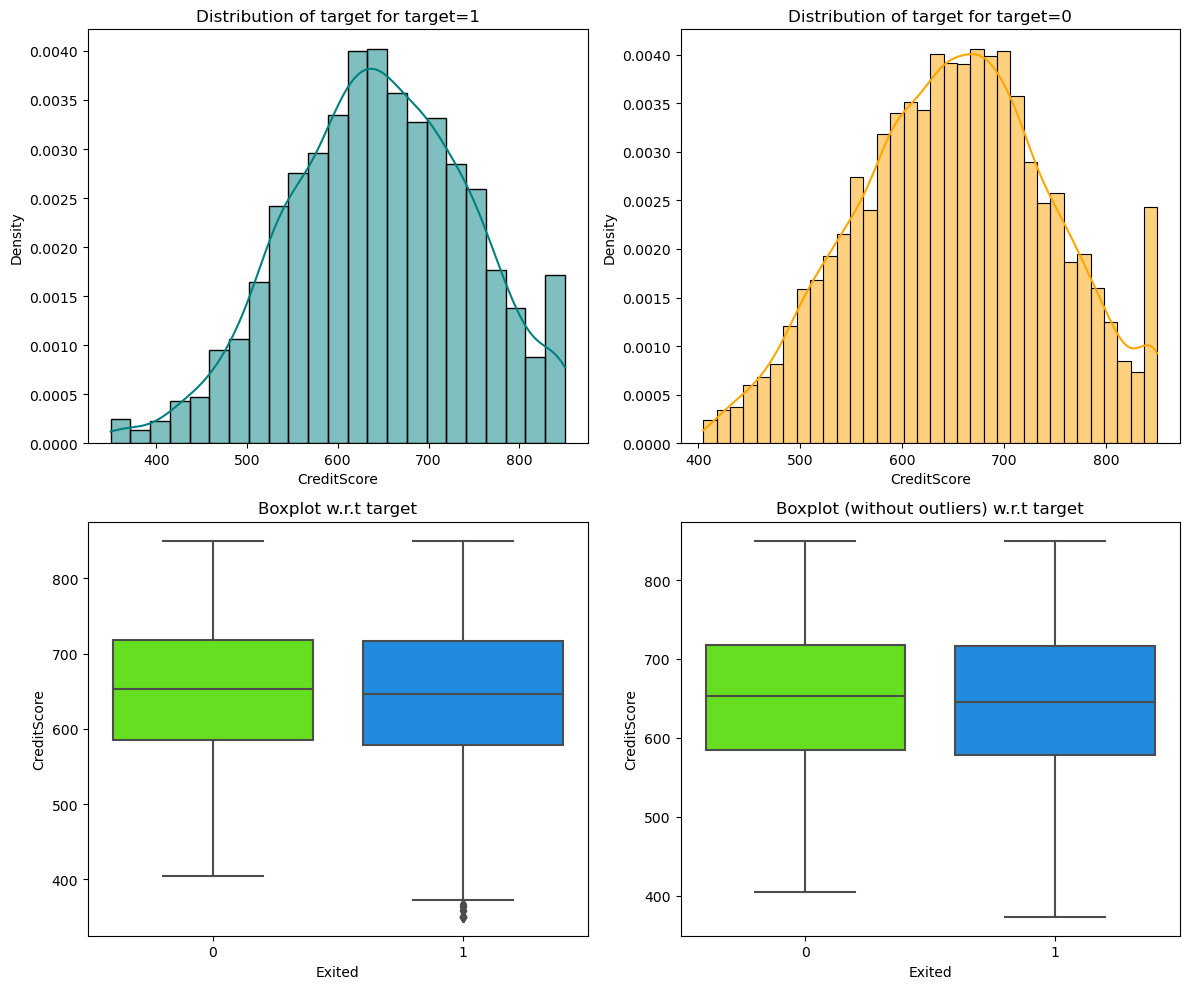

In [ ]:
distribution_plot_wrt_target(df, 'CreditScore', 'Exited')

Observation:
    
* It can be observed tha the  credit score's median of customers that exited is slighty less than credit score's median of customers that did not exit

* This indicates that as the credit score decreases, the propability of exiting increases

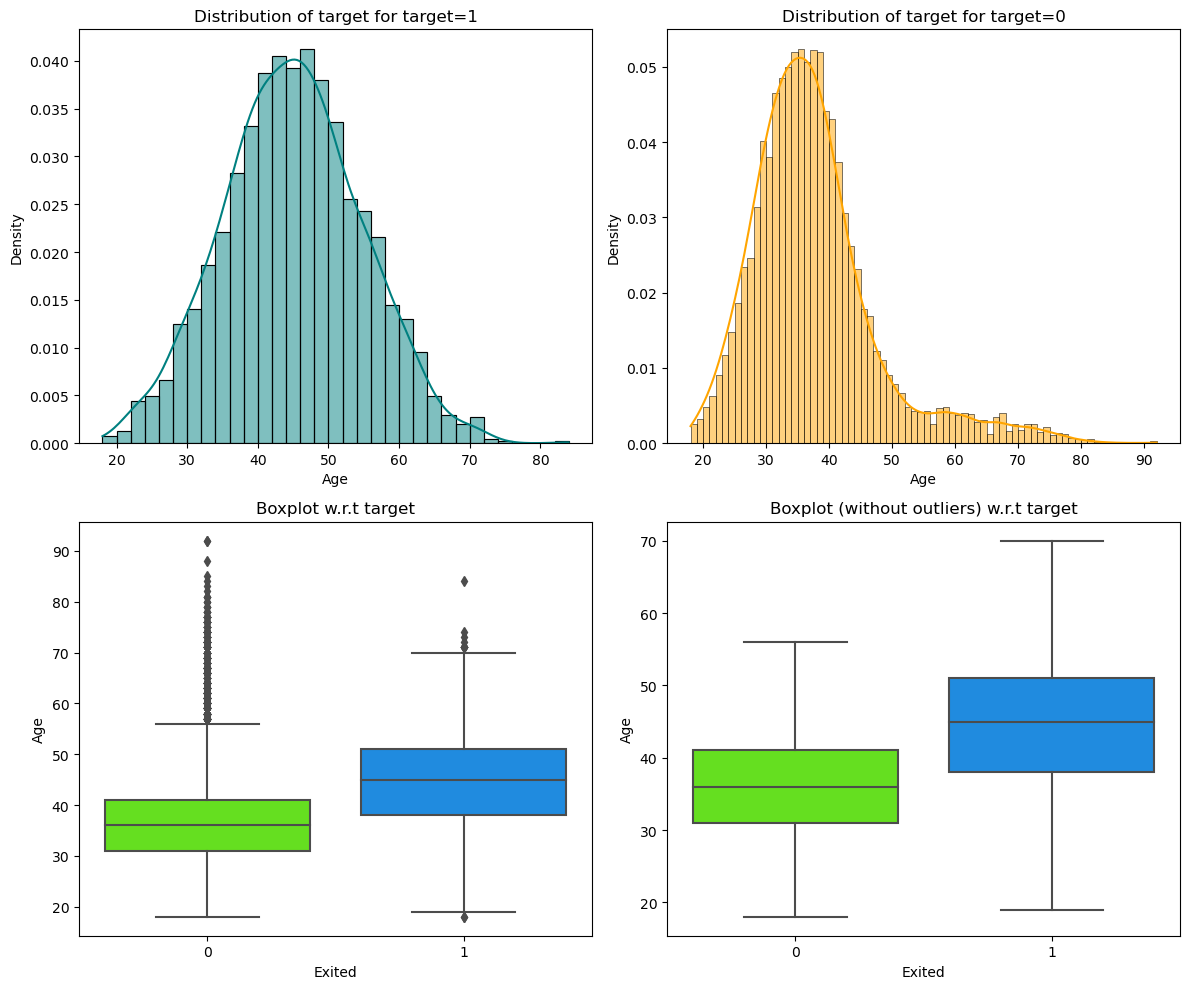

In [ ]:
distribution_plot_wrt_target(df, 'Age', 'Exited')

Observation:
    
* It can be observed tha the median age of customers that exited is greater than median age of customers that did not exit

* This indicates that as the age increases, the propability of exiting increases too

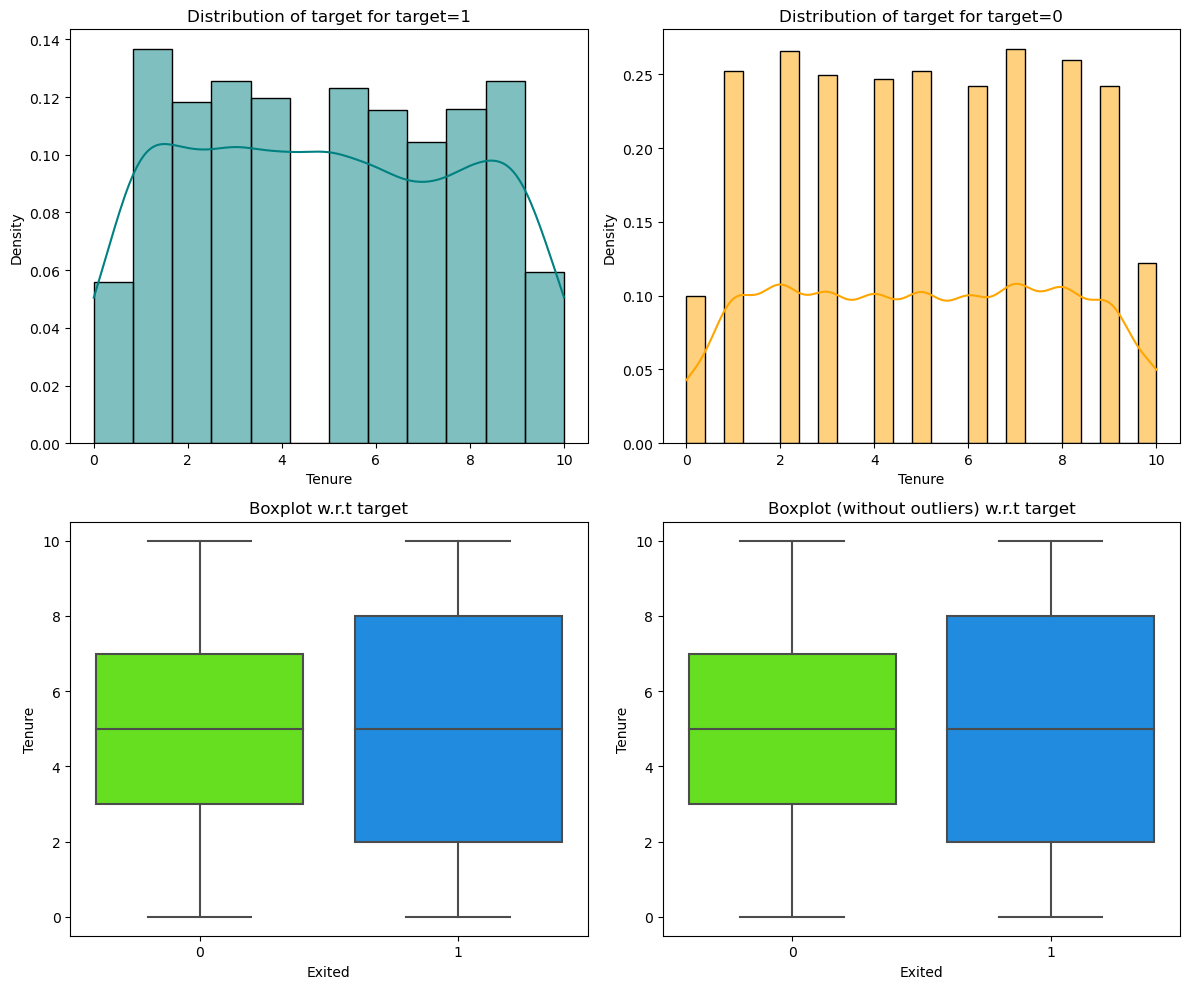

In [ ]:
distribution_plot_wrt_target(df, 'Tenure', 'Exited')

Observation:

* The tenure do not affect the exiting of a customer

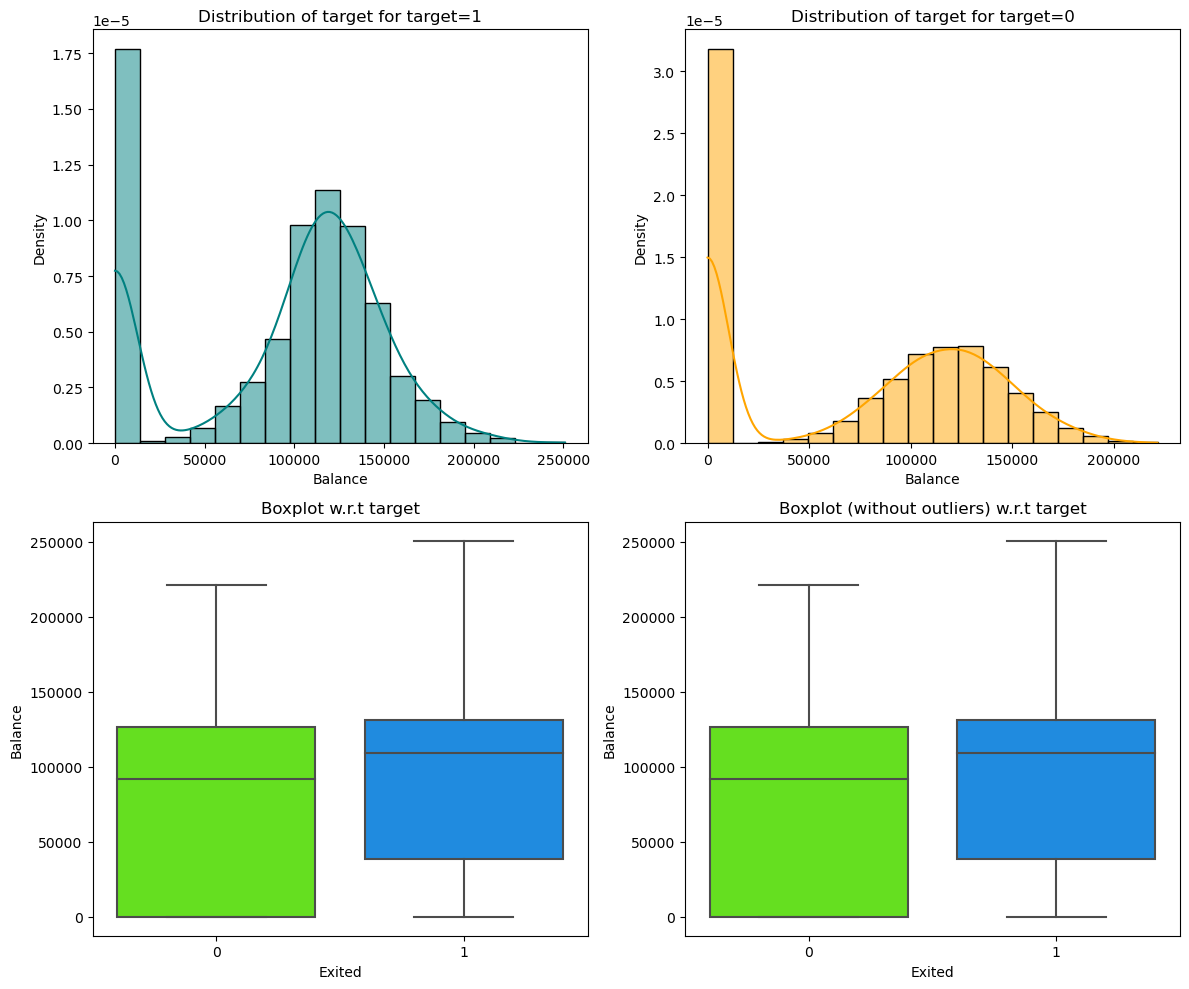

In [ ]:
distribution_plot_wrt_target(df, 'Balance', 'Exited')

Observation:
    
* It can be observed tha the median balance of customers that exited is greater than median balance of customers that did not exit

* This indicates that as the balance increases, the propability of exiting increases too

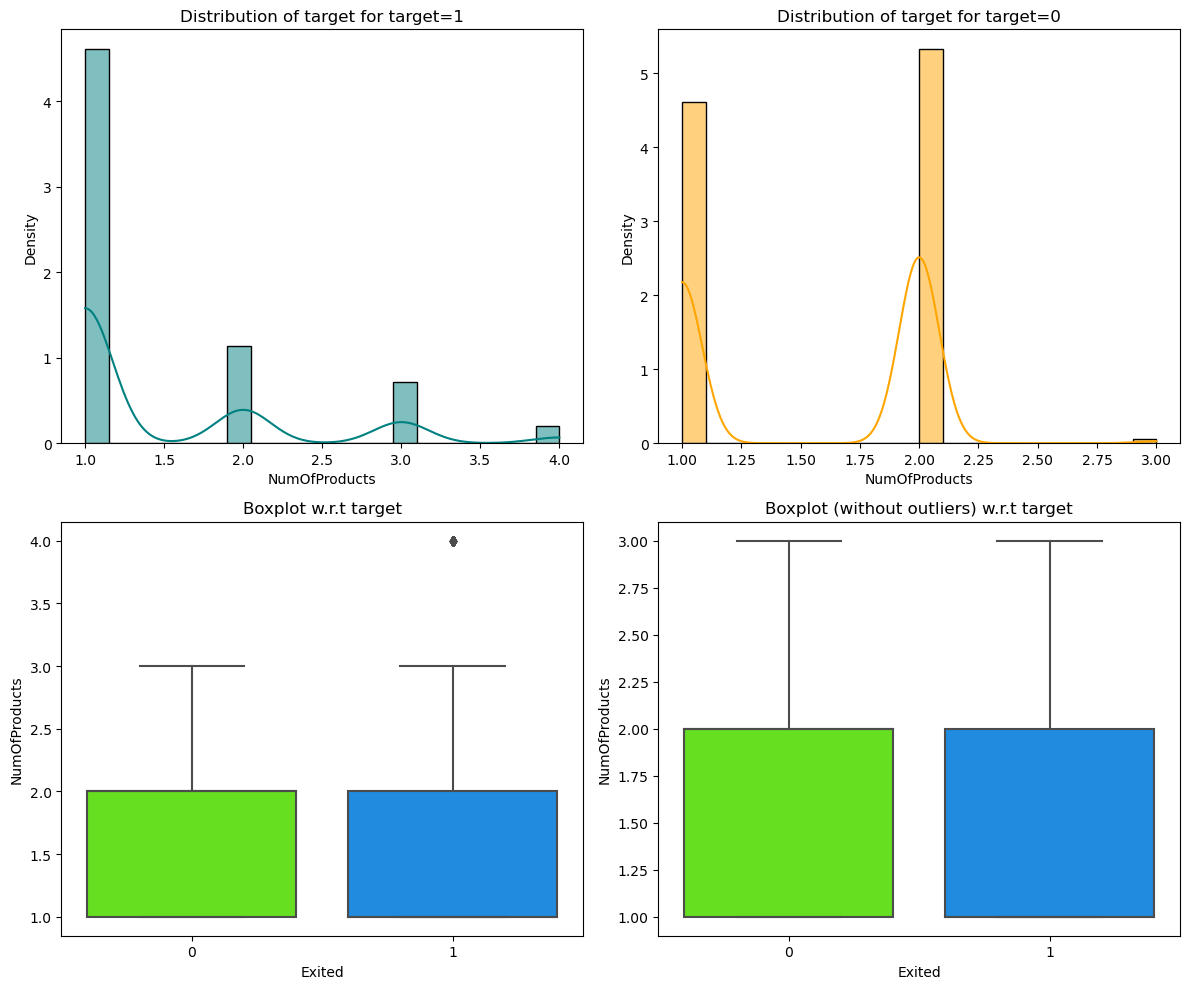

In [ ]:
distribution_plot_wrt_target(df, 'NumOfProducts', 'Exited')

Observation:
    
* Clients with 1 number of product are more likely to live the bank

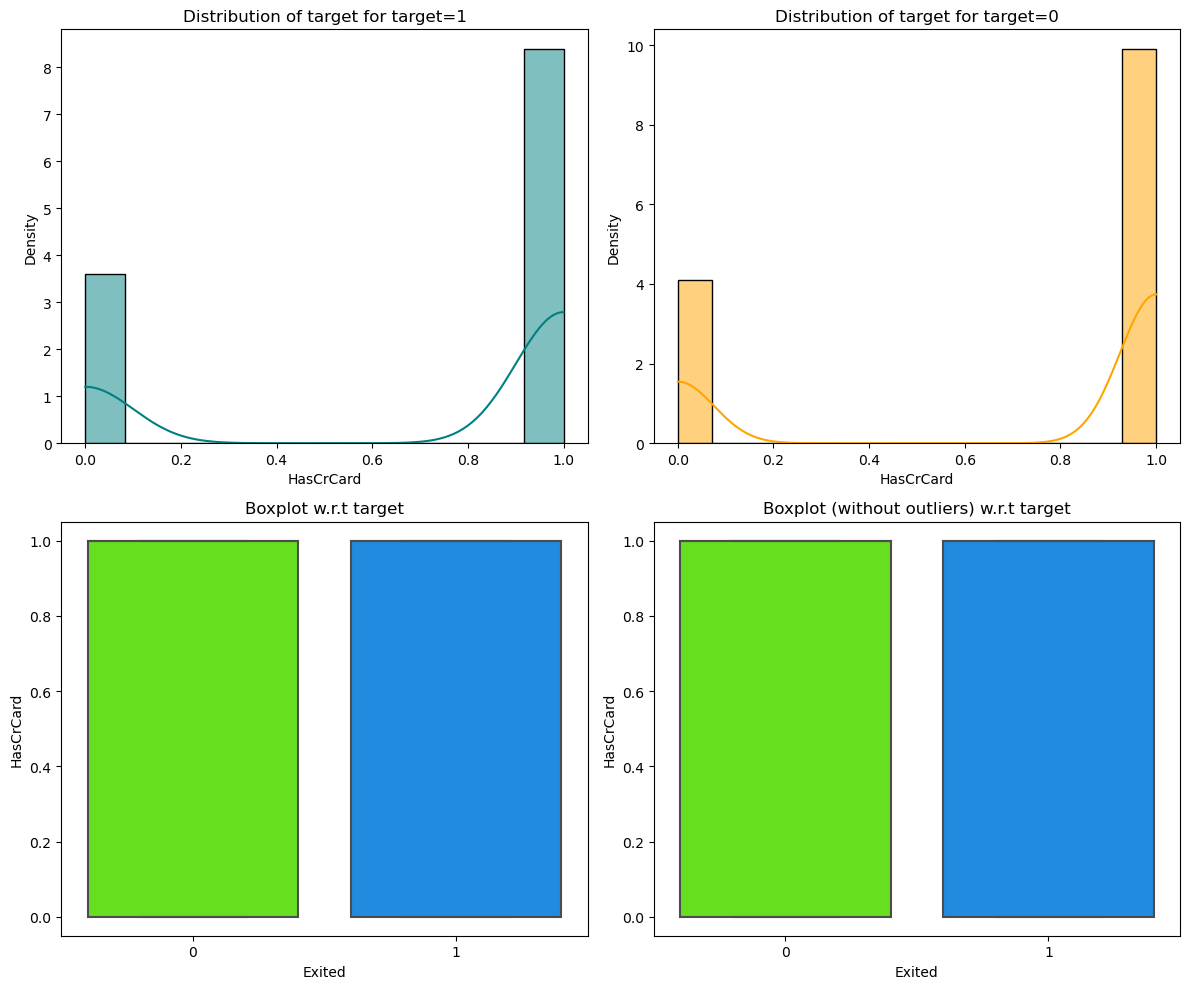

In [ ]:
distribution_plot_wrt_target(df, 'HasCrCard', 'Exited')

Observation:

* Having a credit card or not do not affect the exiting of a customer

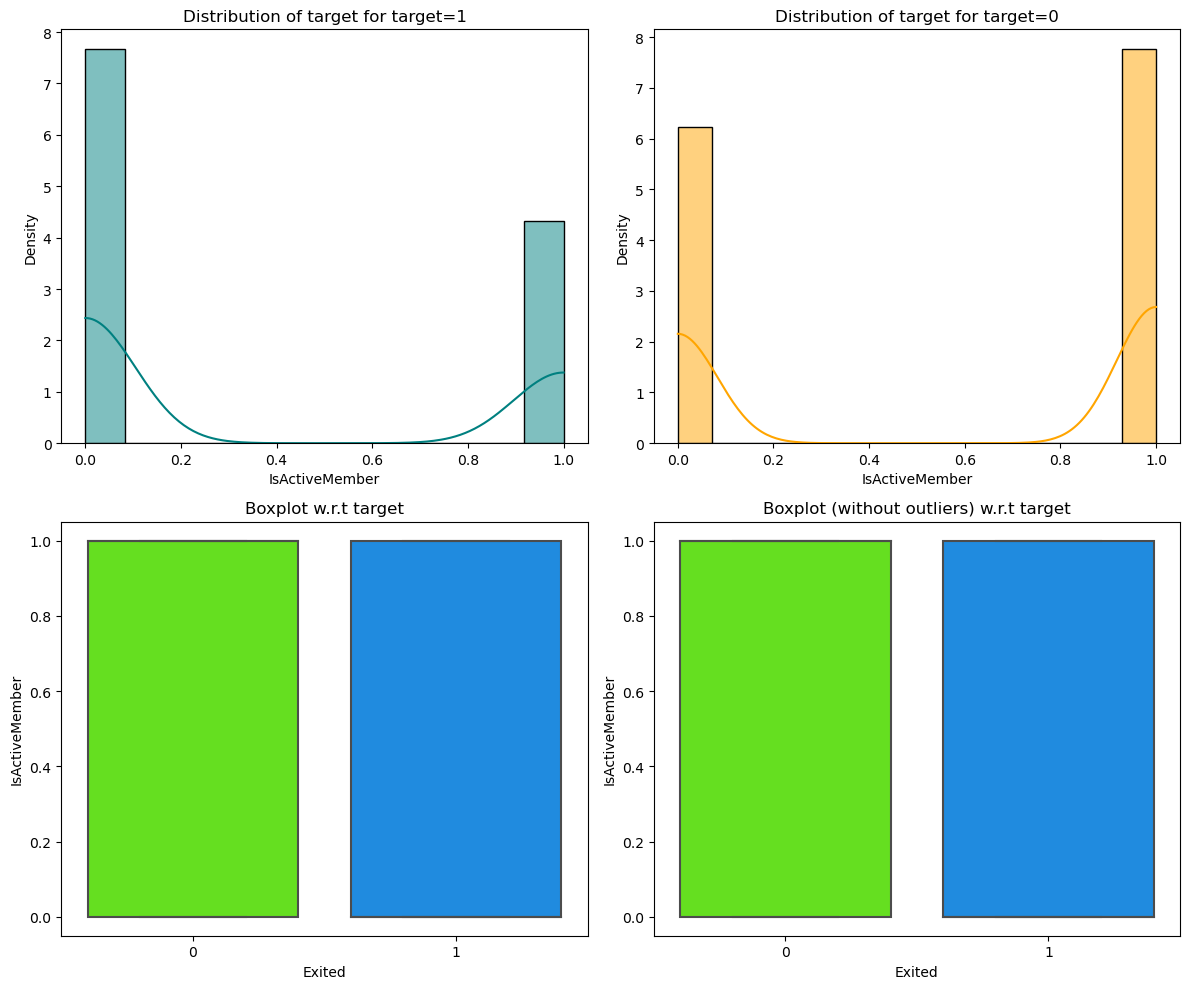

In [ ]:
distribution_plot_wrt_target(df, 'IsActiveMember', 'Exited')

Observation:

* Being an active member or not do not affect the exiting of a customer

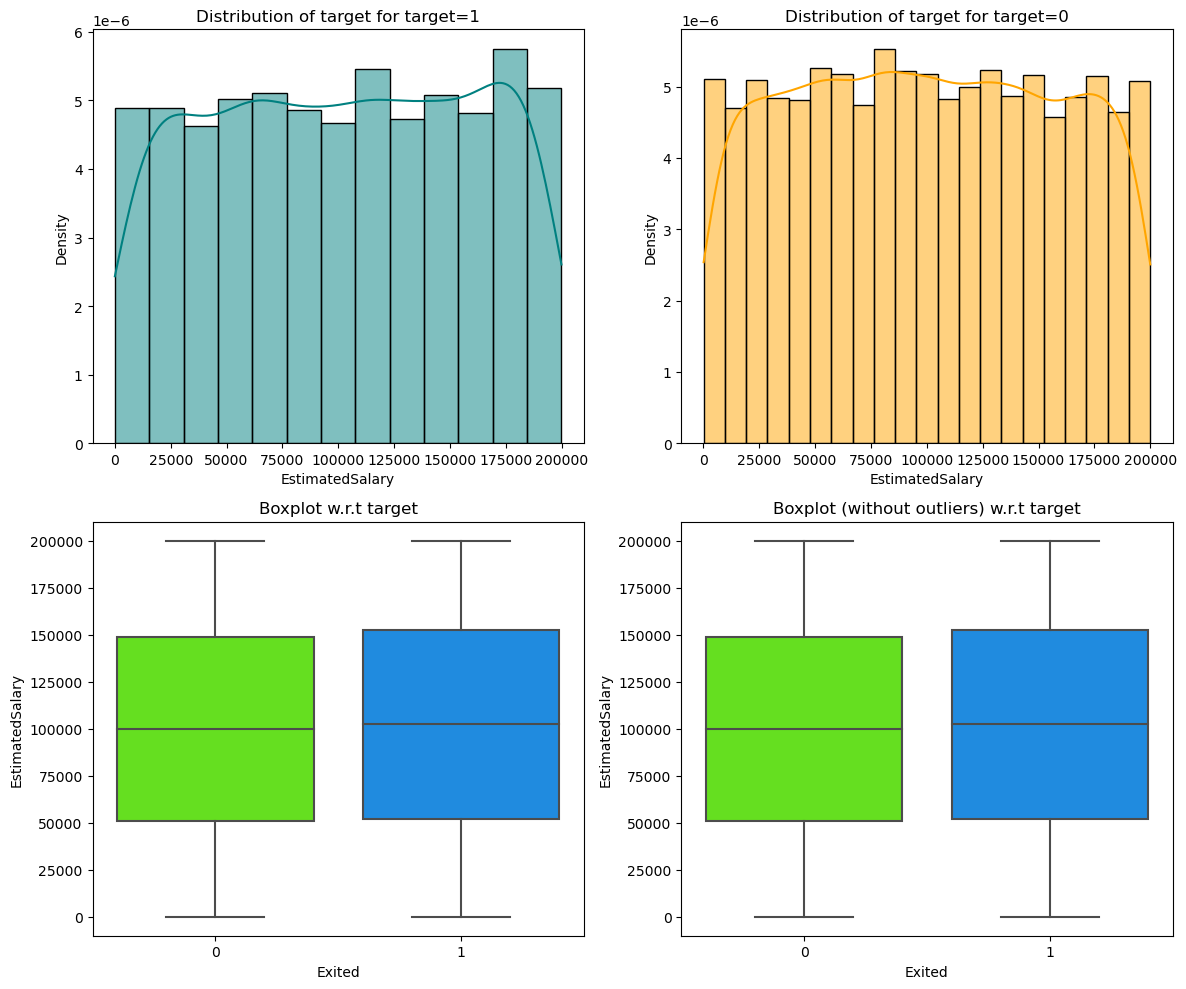

In [ ]:
distribution_plot_wrt_target(df, 'EstimatedSalary', 'Exited')

Observation:
    
* It can be observed tha the  median  estimated salary of customers that exited is slighty greater than  median estimated salary of customers that did not exit

* This indicates that as the estimated salary increases, the propability of exiting increases too

In [ ]:
df.loc[df['Exited']==1,'EstimatedSalary'].median()

102460.84

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


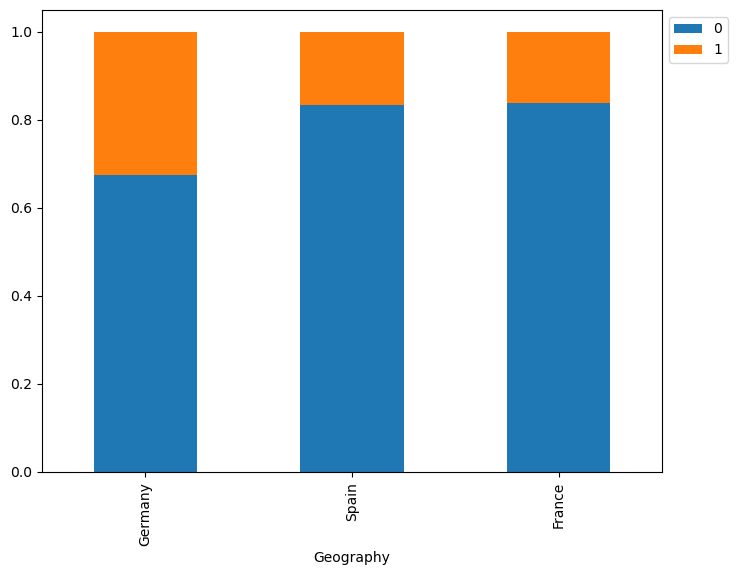

In [ ]:
stacked_barplot(df, 'Geography', 'Exited')

Observation:
    
* Customers from Germany have higher chance of leaving the bank compared to other countries

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


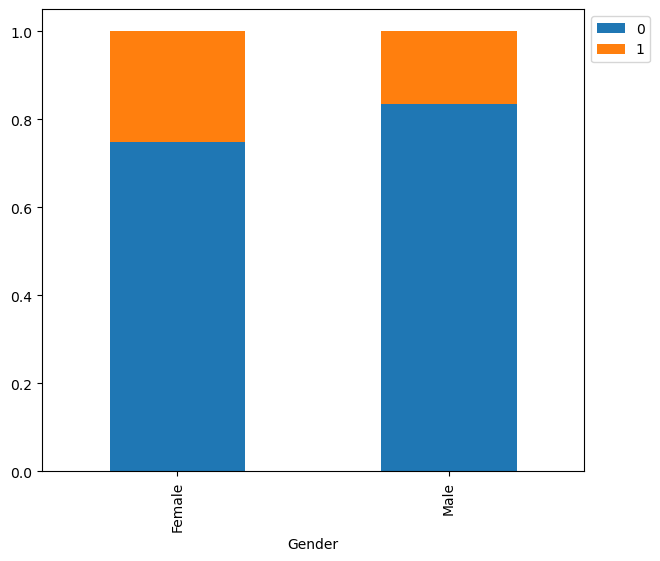

In [ ]:
stacked_barplot(df, 'Gender', 'Exited')

Observation:
    
* Female customers have higher chance of leaving the bank that males    

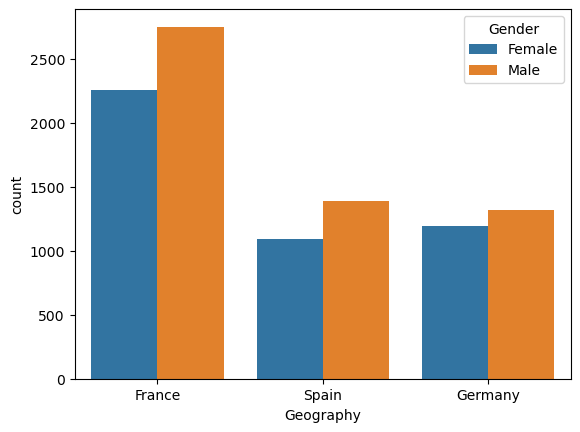

In [ ]:
sns.countplot(data=df,x='Geography',hue='Gender',dodge=True);

Observstion:
    
* The bank has more females client than males in all countries

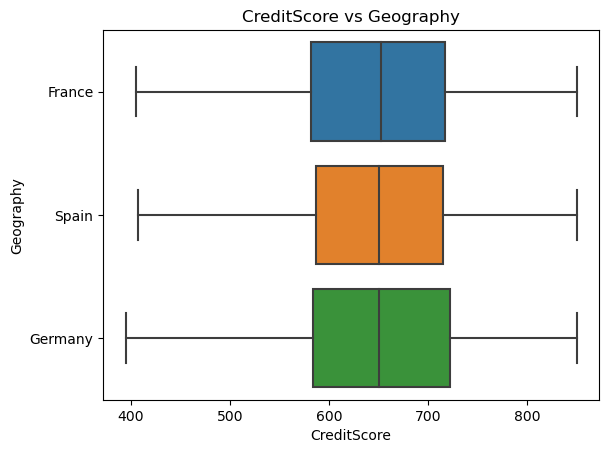

In [ ]:
sns.boxplot(data=df,x='CreditScore',y='Geography',showfliers=False)
plt.title('CreditScore vs Geography')
plt.show()

Observation:

* The 3 countries have the same credit score

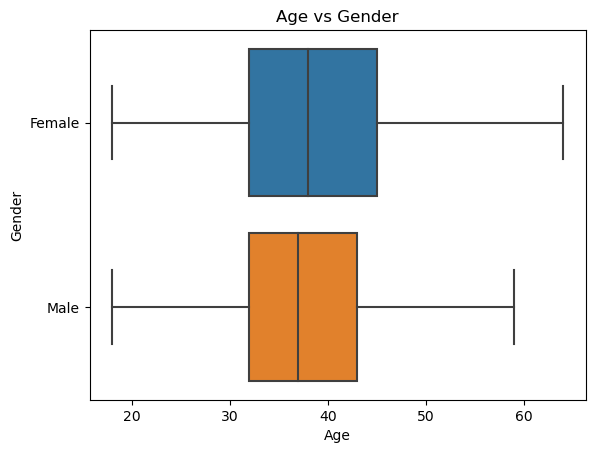

In [ ]:
sns.boxplot(data=df,x='Age',y='Gender',showfliers=False)
plt.title('Age vs Gender')
plt.show()

Observation:
    
* Females are older than males

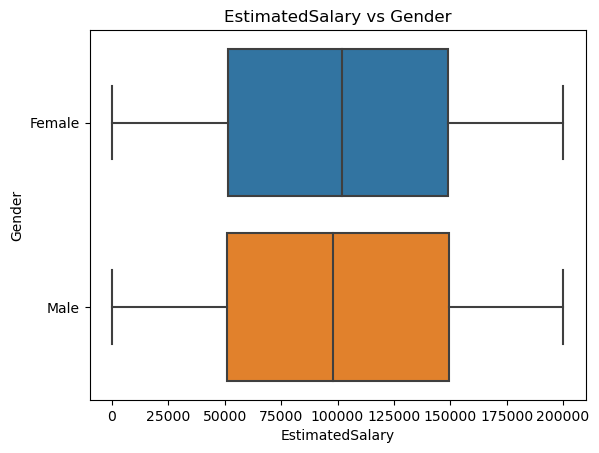

In [ ]:
sns.boxplot(data=df,x='EstimatedSalary',y='Gender')
plt.title('EstimatedSalary vs Gender')
plt.show()

Observation:
    
* Female has slighly higher estimated salary than male

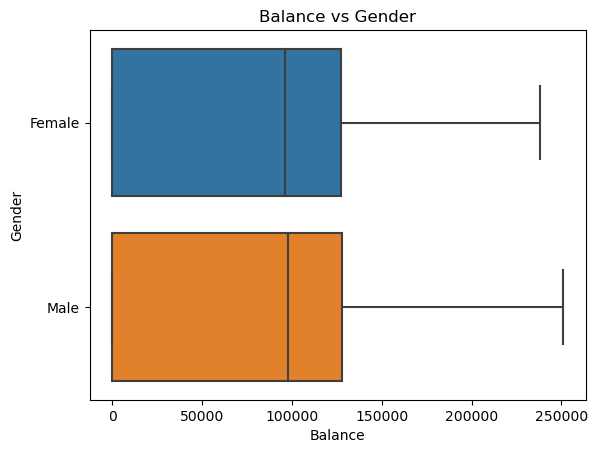

In [ ]:
sns.boxplot(data=df,x='Balance',y='Gender')
plt.title('Balance vs Gender')
plt.show()

Observation:
    
* Both male and female have same balance in their bank accounts

0    7963
1    2037
Name: Exited, dtype: int64


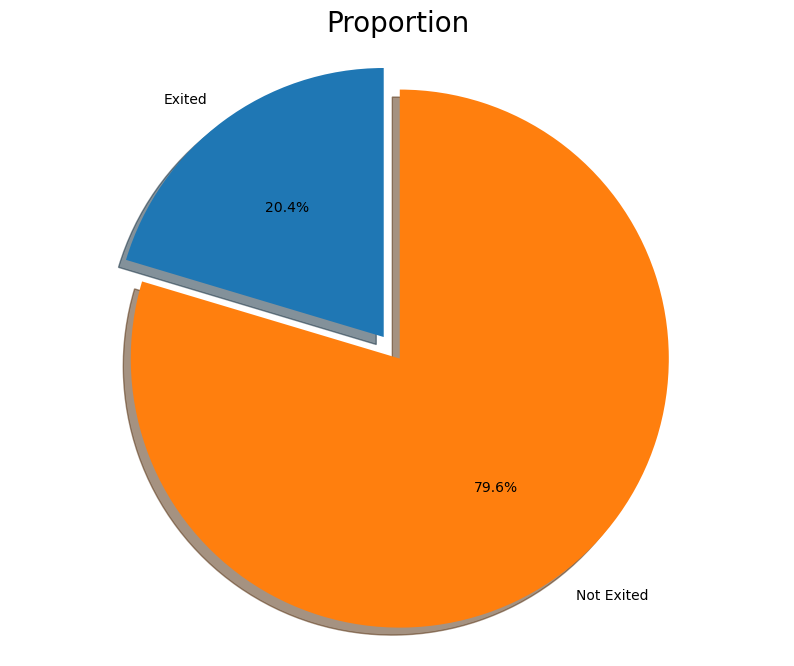

In [ ]:
print(df.Exited.value_counts())
labels = 'Exited', 'Not Exited'
#sizes = [ds.is_promoted[ds['is_promoted']==1].count(), ds.is_promoted[ds['is_promoted']==0].count()]
sizes = [df.Exited[df['Exited']==1].count(),df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion", size = 20)
plt.show()

* This pie chart shows that the target variable is imbalanced.
* Only ~20% of the customers in this dataset exited.


## Data Preparation for modeling

In [ ]:
# Dividing train data into X and y 
X=df.drop('Exited',axis=1)
y=df['Exited']

In [ ]:
df.shape

(10000, 11)

In [ ]:
# Splitting data into training,test sets:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

print(X_train.shape,X_test.shape)

(8000, 10) (2000, 10)


In [ ]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)

X_train.shape,X_test.shape

((8000, 11), (2000, 11))

In [ ]:
scaler =StandardScaler()

X_train_column_headers = list(X_train.columns.values)
X_train[X_train_column_headers] =scaler.fit_transform(X_train[X_train_column_headers])

X_test_column_headers = list(X_test.columns.values)
X_test[X_test_column_headers] =scaler.fit_transform(X_test[X_test_column_headers])

- The Objective is to predict the churn.
- Before you proceed to build a model, you need to split the data into train, test and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale numerical values.
- You will build a model using the train data and then check it's performance

## Model evaluation criterion

### Model can make wrong predictions as:
* Predicting a customer is exiting  and the customer  is not exiting
* Predicting a customer is not exiting and  customer is  exiting

### Which case is more important? 
* Predicting that customer is not exiting but he/she is exiting. It might cause loss to the banks because due to wrong identification bank will not be able to take any initiative for those sensitive customers. 

### How to reduce this loss i.e need to reduce False Negative?
* Bank would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false Negative. Hence, the focus should be on increasing Recall or minimizing the false Negative or in other words identifying the True Positive(i.e. Class 1) so that the bank can retain their customers.

## Initialize & Build the model

#### Clearing the backend session and initializing the random seed values

In [ ]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### Obtaining the train and validation losses

In [ ]:
# Initializing the ANN
model = Sequential()
model.add(Dense(activation = 'relu', input_dim = 11, units=64))
#Add 1st hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation = 'sigmoid')) 

In [ ]:
# Create optimizer with default learning rate
# Compile the model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train, y_train,           
          validation_split=0.2,
          epochs=50,
          batch_size=32,verbose=1)

Epoch 1/50
200/200 [==============================] - 3s 4ms/step - loss: 0.5180 - accuracy: 0.7909 - val_loss: 0.4841 - val_accuracy: 0.7906
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.7998 - val_loss: 0.4596 - val_accuracy: 0.7962
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4398 - accuracy: 0.8059 - val_loss: 0.4456 - val_accuracy: 0.8025
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4275 - accuracy: 0.8138 - val_loss: 0.4360 - val_accuracy: 0.8062
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4192 - accuracy: 0.8175 - val_loss: 0.4292 - val_accuracy: 0.8131
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4130 - accuracy: 0.8197 - val_loss: 0.4231 - val_accuracy: 0.8175
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4077 - accuracy: 0.8233 - val_loss: 0.4180 - val_accuracy: 0.8225
Epoch 

63/63 [==============================] - 1s 2ms/step - loss: 0.3565 - accuracy: 0.8565


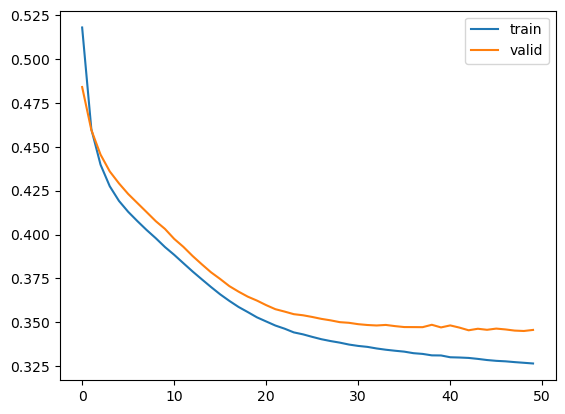

In [ ]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = model.evaluate(X_test, y_test)

In [ ]:
y_pred=model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

#### Let's Plot confusion matrix 

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    
    if title:
        plt.title(title)

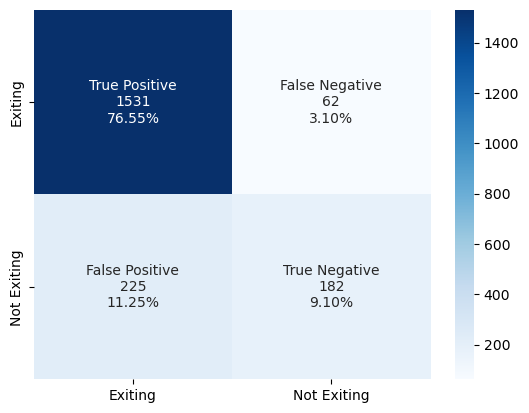

In [ ]:
#Calculating the confusion matrix 
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Exiting','Not Exiting']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
#Accuracy as per the classification report 
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.75      0.45      0.56       407

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



### Building second model with Adam Optimizer

In [ ]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
model1 = Sequential()
      #Adding the hidden and output layers
model1.add(Dense(256,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model1.add(BatchNormalization())
model1.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model1.add(Dense(1, activation = 'sigmoid'))
      #Compiling the ANN with Adam optimizer and binary cross entropy loss function 
optimizer = tf.keras.optimizers.Adam(0.001)
model1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3072      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

In [ ]:
history1 = model1.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
100/100 [==============================] - 3s 8ms/step - loss: 0.4303 - accuracy: 0.8083 - val_loss: 0.4006 - val_accuracy: 0.8313
Epoch 2/50
100/100 [==============================] - 1s 5ms/step - loss: 0.3490 - accuracy: 0.8562 - val_loss: 0.3661 - val_accuracy: 0.8469
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3311 - accuracy: 0.8595 - val_loss: 0.3529 - val_accuracy: 0.8550
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3191 - accuracy: 0.8653 - val_loss: 0.3599 - val_accuracy: 0.8500
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3101 - accuracy: 0.8683 - val_loss: 0.3613 - val_accuracy: 0.8494
Epoch 6/50
100/100 [==============================] - 0s 5ms/step - loss: 0.3033 - accuracy: 0.8697 - val_loss: 0.3691 - val_accuracy: 0.8450
Epoch 7/50
100/100 [==============================] - 0s 5ms/step - loss: 0.2970 - accuracy: 0.8758 - val_loss: 0.3696 - val_accuracy: 0.8438
Epoch 

Lets plot the loss function again

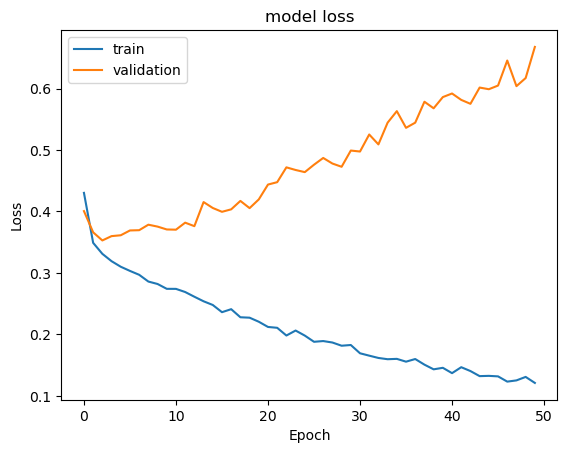

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Let's tune the threshold using ROC-AUC**


There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.

Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.

Sensitivity = TruePositive / (TruePositive + FalseNegative)


Specificity = TrueNegative / (FalsePositive + TrueNegative)

Where:

Sensitivity = True Positive Rate

Specificity = 1 – False Positive Rate

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

G-Mean = sqrt(Sensitivity * Specificity)

One approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value.

Best Threshold=0.060848, G-Mean=0.729


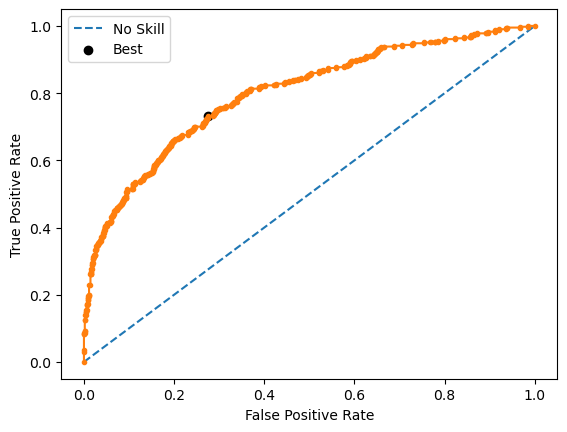

In [ ]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat1 = model1.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#Predicting the results using best as a threshold
y_pred_e1=model1.predict(X_test)
y_pred_e1 = (y_pred_e1 > thresholds1[ix])
y_pred_e1

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

Accuracy, Precision, Recall, and F1-Scores

In [ ]:
#Accuracy as per the classification report 
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred_e1)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1593
           1       0.40      0.73      0.52       407

    accuracy                           0.73      2000
   macro avg       0.66      0.73      0.66      2000
weighted avg       0.81      0.73      0.75      2000



Printing Confusion matrix

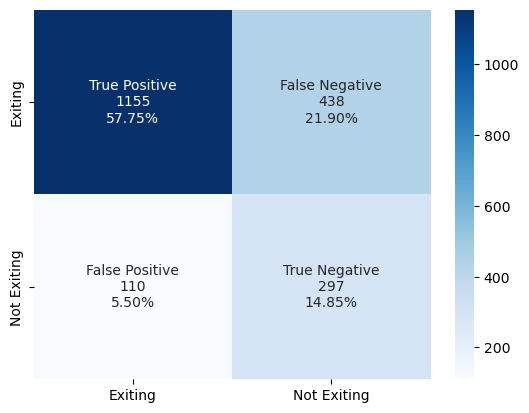

In [ ]:
#Calculating the confusion matrix 
from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(y_test, y_pred_e1)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Exiting','Not Exiting']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

## Building the third Model

#### Hyperparameter Optimization

Some important parameters to look out for while optimizing neural networks are:

-Type of architecture

-Number of Layers

-Number of Neurons in a layer

-Regularization parameters

-Learning Rate

-Type of optimization / backpropagation technique to use

-Dropout rate

-Weight sharing

### Building a model and tuning it using hyperparameter tuning

##### Using Grid search

We are using grid search to optimize two hyperparameters called **learning rate,batch size, epochs,Optimizer,activation fuction,dropout and Network Weight Initialization** due to the limited time. But you can optimize the other hyperparameters as mentioned above

In [ ]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
def create_model_v3(lr,batch_size,epoch,optimizer,activation,init_mode):  
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(256,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu',kernel_initializer='he_uniform')) 
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
keras_estimator = KerasClassifier(build_fn=create_model_v3, verbose=2)
# define the grid search parameters
param_random = {
    'batch_size':[20,25,32, 64, 128,356],
    "lr":[0.01,0.1,0.001,0.0001,0.02,0.03],
    "epoch":[10,15,20,35,50,100,150],
    "init_mode":['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    "optimizer":['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "activation":['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    
}

kfold_splits = 10
random= RandomizedSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_distributions=param_random,n_jobs=-1)

In [ ]:
%%time

random_result = random.fit(X_train, y_train,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Fitting 10 folds for each of 10 candidates, totalling 100 fits
320/320 [==============================] - 6s 6ms/step - loss: 0.4915 - accuracy: 0.8003 - val_loss: 0.4294 - val_accuracy: 0.8231
Best: 0.826125 using {'optimizer': 'Adadelta', 'lr': 0.01, 'init_mode': 'uniform', 'epoch': 100, 'batch_size': 20, 'activation': 'softplus'}
CPU times: total: 5.98 s
Wall time: 2min 15s


## Let's create the final model with the obtained configuration after hyperparameter tuning

In [ ]:
estimator_v3=create_model_v3(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'],
                            epoch=random_result.best_params_['epoch'],activation=random_result.best_params_['activation'],
                            optimizer=random_result.best_params_['optimizer'],init_mode=random_result.best_params_['init_mode'])

estimator_v3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               3072      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [ ]:
optimizer = tf.keras.optimizers.Adadelta(random_result.best_params_['lr'])
estimator_v3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_3=estimator_v3.fit(X_train, y_train, epochs=100, batch_size =20, verbose=1,validation_split=0.2)

Epoch 1/100
320/320 [==============================] - 4s 4ms/step - loss: 0.7715 - accuracy: 0.7033 - val_loss: 0.6159 - val_accuracy: 0.7256
Epoch 2/100
320/320 [==============================] - 1s 4ms/step - loss: 0.7292 - accuracy: 0.7178 - val_loss: 0.5818 - val_accuracy: 0.7469
Epoch 3/100
320/320 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.7328 - val_loss: 0.5603 - val_accuracy: 0.7644
Epoch 4/100
320/320 [==============================] - 1s 4ms/step - loss: 0.6538 - accuracy: 0.7439 - val_loss: 0.5469 - val_accuracy: 0.7713
Epoch 5/100
320/320 [==============================] - 1s 3ms/step - loss: 0.6392 - accuracy: 0.7442 - val_loss: 0.5352 - val_accuracy: 0.7763
Epoch 6/100
320/320 [==============================] - 1s 3ms/step - loss: 0.6237 - accuracy: 0.7545 - val_loss: 0.5276 - val_accuracy: 0.7750
Epoch 7/100
320/320 [==============================] - 1s 3ms/step - loss: 0.5926 - accuracy: 0.7578 - val_loss: 0.5210 - val_accuracy: 0.7700

Epoch 58/100
320/320 [==============================] - 1s 4ms/step - loss: 0.4676 - accuracy: 0.8003 - val_loss: 0.4416 - val_accuracy: 0.8087
Epoch 59/100
320/320 [==============================] - 1s 3ms/step - loss: 0.4698 - accuracy: 0.7958 - val_loss: 0.4404 - val_accuracy: 0.8106
Epoch 60/100
320/320 [==============================] - 1s 3ms/step - loss: 0.4733 - accuracy: 0.8008 - val_loss: 0.4395 - val_accuracy: 0.8100
Epoch 61/100
320/320 [==============================] - 1s 3ms/step - loss: 0.4685 - accuracy: 0.7992 - val_loss: 0.4390 - val_accuracy: 0.8106
Epoch 62/100
320/320 [==============================] - 1s 3ms/step - loss: 0.4615 - accuracy: 0.8006 - val_loss: 0.4381 - val_accuracy: 0.8100
Epoch 63/100
320/320 [==============================] - 1s 3ms/step - loss: 0.4614 - accuracy: 0.7980 - val_loss: 0.4373 - val_accuracy: 0.8112
Epoch 64/100
320/320 [==============================] - 1s 3ms/step - loss: 0.4590 - accuracy: 0.8006 - val_loss: 0.4368 - val_accuracy:

Plotting the validation and training loss

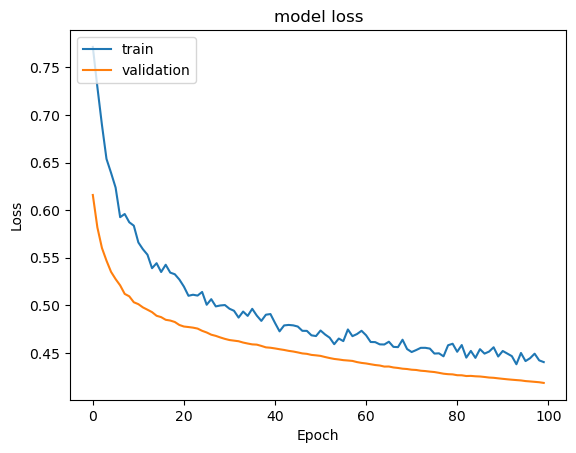

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Tuning the threshold using ROC

Best Threshold=0.315734, G-Mean=0.754


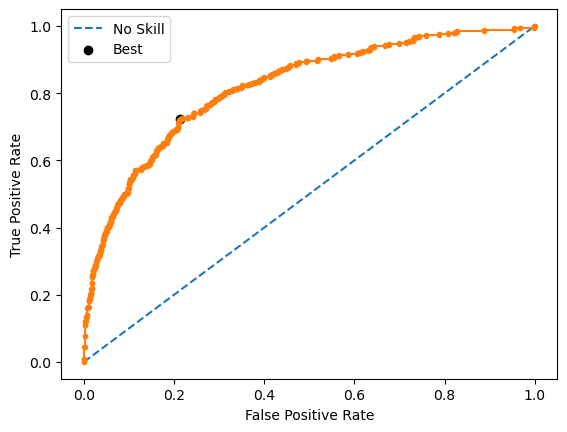

In [ ]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat3 = estimator_v3.predict(X_test)
# keep probabilities for the positive outcome only
yhat3 = yhat3[:, 0]
# calculate roc curves
fpr, tpr, thresholds3 = roc_curve(y_test, yhat3)
# calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds3[ix], gmeans3[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_pred_e3=estimator_v3.predict(X_test)
y_pred_e3 = (y_pred_e3 > thresholds3[ix])
y_pred_e3

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

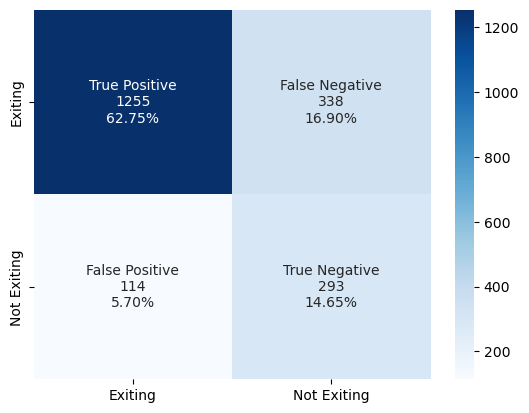

In [ ]:
#Calculating the confusion matrix 
from sklearn.metrics import confusion_matrix
cm3=confusion_matrix(y_test, y_pred_e3)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Exiting','Not Exiting']
make_confusion_matrix(cm3, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
#Accuracy as per the classification report 
from sklearn import metrics
cr3=metrics.classification_report(y_test,y_pred_e3)
print(cr3)

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1593
           1       0.46      0.72      0.56       407

    accuracy                           0.77      2000
   macro avg       0.69      0.75      0.71      2000
weighted avg       0.82      0.77      0.79      2000



## Build a model with Balanced Dataset

**Now try to apply SMOTE to balance this dataset and then again apply hyperparamter tuning accordingly.**

### Model Building with Oveersampled data

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 1630
Before OverSampling, counts of label '0': 6370 

After OverSampling, counts of label '1': 6370
After OverSampling, counts of label '0': 6370 

After OverSampling, the shape of train_X: (12740, 11)
After OverSampling, the shape of train_y: (12740,) 



In [ ]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
def build_model(h):
    model = keras.Sequential()
    for i in range(h.Int('num_layers', 2, 5)):
        model.add(layers.Dense(units=h.Int('units_' + str(i),
                                            min_value=30,
                                            max_value=500,
                                            step=10),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            h.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=7,
    executions_per_trial=3,
     project_name='project')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 500, 'step': 10, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 500, 'step': 10, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train_over, y_train_over,
             epochs=5,
             validation_split = 0.2)

Trial 7 Complete [00h 00m 33s]
val_accuracy: 0.6972789168357849

Best val_accuracy So Far: 0.8822606007258097
Total elapsed time: 00h 04m 11s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in .\project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 300
units_1: 380
learning_rate: 0.0001
units_2: 400
units_3: 460
units_4: 210
Score: 0.8822606007258097
Trial summary
Hyperparameters:
num_layers: 3
units_0: 320
units_1: 270
learning_rate: 0.001
units_2: 430
units_3: 210
units_4: 400
Score: 0.8350340127944946
Trial summary
Hyperparameters:
num_layers: 3
units_0: 270
units_1: 70
learning_rate: 0.001
units_2: 50
units_3: 440
units_4: 170
Score: 0.801805337270101
Trial summary
Hyperparameters:
num_layers: 4
units_0: 210
units_1: 70
learning_rate: 0.01
units_2: 190
units_3: 170
units_4: 460
Score: 0.7624280452728271
Trial summary
Hyperparameters:
num_layers: 3
units_0: 270
units_1: 110
learning_rate: 0.01
units_2: 410
units_3: 330
units_4: 110
Score: 0.755756159623464
Trial summary
Hyperparameters:
num_layers: 5
units_0: 390
units_1: 160
learning_rate: 0.0001
units_2: 30
units_3: 30
units_4: 30
Score: 0.7377027670542399
Trial 

In [ ]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#adding earlystopping callback
es= keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              min_delta=0.01,
                              patience=15,
 
                             verbose=1, mode='max', restore_best_weights= True)

n_inputs = X_train.shape[1]
model4 = Sequential()
model4.add(Dense(300,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model4.add(Dropout(0.2))
model4.add(Dense(380,activation='relu',kernel_initializer='he_uniform'))
model4.add(Dropout(0.2))
model4.add(Dense(400,activation='relu',kernel_initializer='he_uniform'))
model4.add(Dropout(0.2))
model4.add(Dense(460,activation='relu',kernel_initializer='he_uniform'))
model4.add(Dropout(0.2))
model4.add(Dense(210,activation='relu',kernel_initializer='he_uniform'))
model4.add(Dense(1, activation = 'sigmoid'))
      #Compiling the ANN with Adam optimizer and binary cross entropy loss function 
optimizer = tf.keras.optimizers.Adam(0.0001)
model4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               3600      
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 380)               114380    
                                                                 
 dropout_1 (Dropout)         (None, 380)               0         
                                                                 
 dense_2 (Dense)             (None, 400)               152400    
                                                                 
 dropout_2 (Dropout)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 460)               1

In [ ]:
history_4 = model4.fit(X_train_over,y_train_over,batch_size=20,epochs=500,verbose=1,validation_split = 0.2,callbacks=[es], shuffle=True)

Epoch 1/500
510/510 [==============================] - 7s 11ms/step - loss: 0.6209 - accuracy: 0.6776 - val_loss: 0.4869 - val_accuracy: 0.7681
Epoch 2/500
510/510 [==============================] - 6s 11ms/step - loss: 0.5402 - accuracy: 0.7335 - val_loss: 0.5156 - val_accuracy: 0.7304
Epoch 3/500
510/510 [==============================] - 5s 11ms/step - loss: 0.5028 - accuracy: 0.7519 - val_loss: 0.4951 - val_accuracy: 0.7567
Epoch 4/500
510/510 [==============================] - 5s 11ms/step - loss: 0.4840 - accuracy: 0.7674 - val_loss: 0.4905 - val_accuracy: 0.7355
Epoch 5/500
510/510 [==============================] - 5s 11ms/step - loss: 0.4647 - accuracy: 0.7780 - val_loss: 0.4192 - val_accuracy: 0.7924
Epoch 6/500
510/510 [==============================] - 5s 11ms/step - loss: 0.4557 - accuracy: 0.7828 - val_loss: 0.4732 - val_accuracy: 0.7516
Epoch 7/500
510/510 [==============================] - 6s 12ms/step - loss: 0.4488 - accuracy: 0.7890 - val_loss: 0.5201 - val_accuracy:

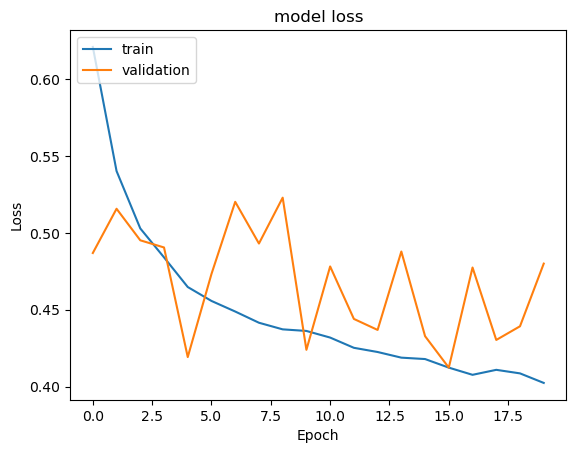

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Best Threshold=0.441478, G-Mean=0.766


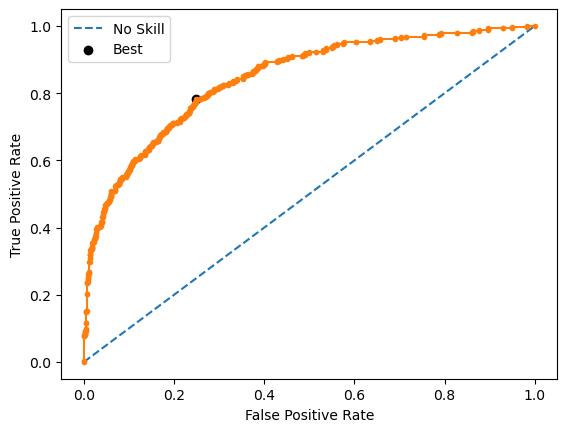

In [ ]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat4 = model4.predict(X_test)
# keep probabilities for the positive outcome only
yhat4 = yhat4[:, 0]
# calculate roc curves
fpr, tpr, thresholds4 = roc_curve(y_test, yhat9)
# calculate the g-mean for each threshold
gmeans4 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans4)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds4[ix], gmeans4[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_pred_e4=model4.predict(X_test)
y_pred_e4 = (y_pred_e4 > thresholds4[ix])
y_pred_e4

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

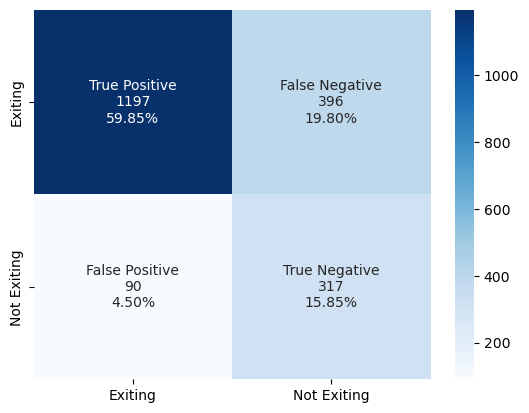

In [ ]:
#Calculating the confusion matrix 
from sklearn.metrics import confusion_matrix
cm4=confusion_matrix(y_test, y_pred_e4)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Exiting','Not Exiting']
make_confusion_matrix(cm4, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
#Accuracy as per the classification report 
from sklearn import metrics
cr4=metrics.classification_report(y_test,y_pred_e4)
print(cr4)

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1593
           1       0.44      0.78      0.57       407

    accuracy                           0.76      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.83      0.76      0.78      2000



## Actionable Insights and Recommendations 

---



* Our final model is **Model 4**, which uses the Dropout regularization technique and works on the balanced dataset.
* The bank should approach clients that have credit score 646 and less and see how they can help them before they live the bank
* The bank should give excellent service and constantly talk to clients aged 45 and above as they have high chance of leaving the bank
* The bank should reverse excellent service to client with 109349.29 and above balance in their accounts
* The bank must assure that maximum of their clients have 2 or more number of products 
* The bank should reverse excellent service to client with 102460.84 and above estimated salary
* The bank must put much more effort in Germany to reduce the number of clients leaving them
* The bank should create more products suitable to female and also giving them gifts to be able to keep them



#### Happy Learning!